# Exercise 1 Solution: SEIRS Model for a Different Country

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/epistorm/tech-transfer-epydemix/blob/main/sessions/session-4/solutions/python/exercise_1_seirs_model.ipynb)

Build an SEIRS model (with waning immunity) and simulate it for a country of your choice.

In [1]:
# Colab installation (skip if running locally)
import sys, os, subprocess
if "google.colab" in sys.modules or os.getenv("COLAB_RELEASE_TAG"):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-r",
                    "https://raw.githubusercontent.com/epistorm/epydemix/refs/heads/main/tutorials/colab_requirements.txt"])

## Task 1: Create the SEIRS Model

The SEIRS model extends SEIR by adding waning immunity (R → S transition).

In [2]:
from epydemix import EpiModel

# Create SEIRS model
model = EpiModel(name="SEIRS Model", compartments=["S", "E", "I", "R"])

# S → E: infection (mediated by I)
model.add_transition(source="S", target="E", params=("beta", "I"), kind="mediated")

# E → I: progression to infectious
model.add_transition(source="E", target="I", params="sigma", kind="spontaneous")

# I → R: recovery
model.add_transition(source="I", target="R", params="gamma", kind="spontaneous")

# R → S: waning immunity (the key addition for SEIRS)
model.add_transition(source="R", target="S", params="omega", kind="spontaneous")

# Set parameters
model.add_parameter("beta", 0.03)    # transmission rate
model.add_parameter("sigma", 0.2)    # 1/5 day latent period
model.add_parameter("gamma", 0.1)    # 1/10 day infectious period
model.add_parameter("omega", 0.01)   # 1/100 day immunity duration

print(model)

EpiModel(name='SEIRS Model')
Compartments: 4
  S, E, I, R
Transitions: 4
  Transitions between compartments:
    S -> E, params: ('beta', 'I') (kind: mediated)
    E -> I, params: sigma (kind: spontaneous)
    I -> R, params: gamma (kind: spontaneous)
    R -> S, params: omega (kind: spontaneous)
Parameters: 4
  Model parameters:
    beta: 0.03
    sigma: 0.2
    gamma: 0.1
    omega: 0.01
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



## Task 2: Load Population Data

Let's use Brazil as our example country.

In [3]:
from epydemix.population import load_epydemix_population

# Load Brazil population data
population = load_epydemix_population("Brazil")
model.set_population(population)

print(population)

Population(name='Brazil')
Demographic groups: 5 groups
Population distribution:
  - 0-4: 13218241 individuals
  - 5-19: 43651312 individuals
  - 20-49: 96265908 individuals
  - 50-64: 35514607 individuals
  - 65+: 22924390 individuals
Contact matrices: 4 layers
Available layers:
  - school
  - work
  - home
  - community



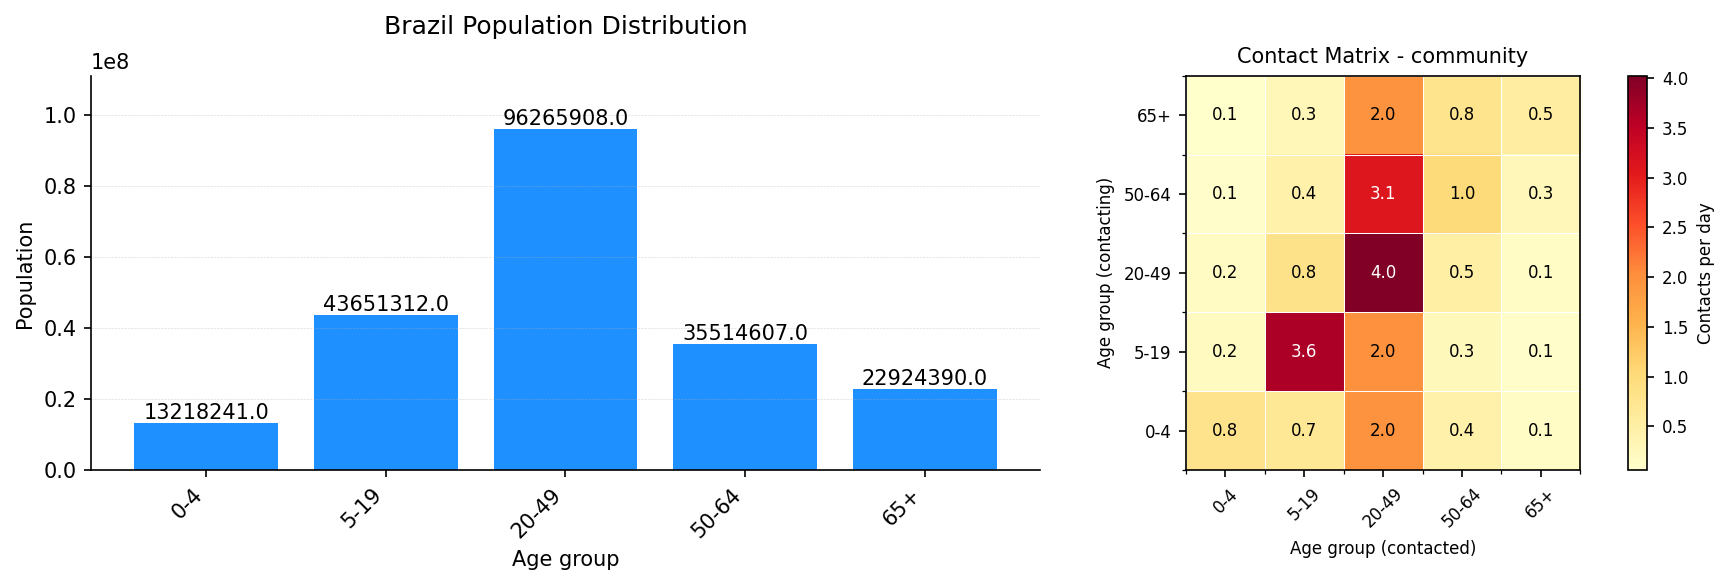

In [4]:
from epydemix.visualization import plot_population, plot_contact_matrix
import matplotlib.pyplot as plt

# Visualize population and contacts
fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

plot_population(population, ax=axes[0], title="Brazil Population Distribution")
plot_contact_matrix(population, "community", ax=axes[1], fontsize=8, show_values=True)

plt.tight_layout()

## Task 3: Run Simulations and Visualize

In [5]:
import numpy as np

# Run 50 simulations over 1 year
results = model.run_simulations(
    start_date="2026-01-01",
    end_date="2026-12-31",
    Nsim=50,
    percentage_in_agents=10 / population.Nk.sum()  # seed with ~10 infected
)

<Axes: title={'center': 'SEIRS Model - Brazil (1 Year)'}>

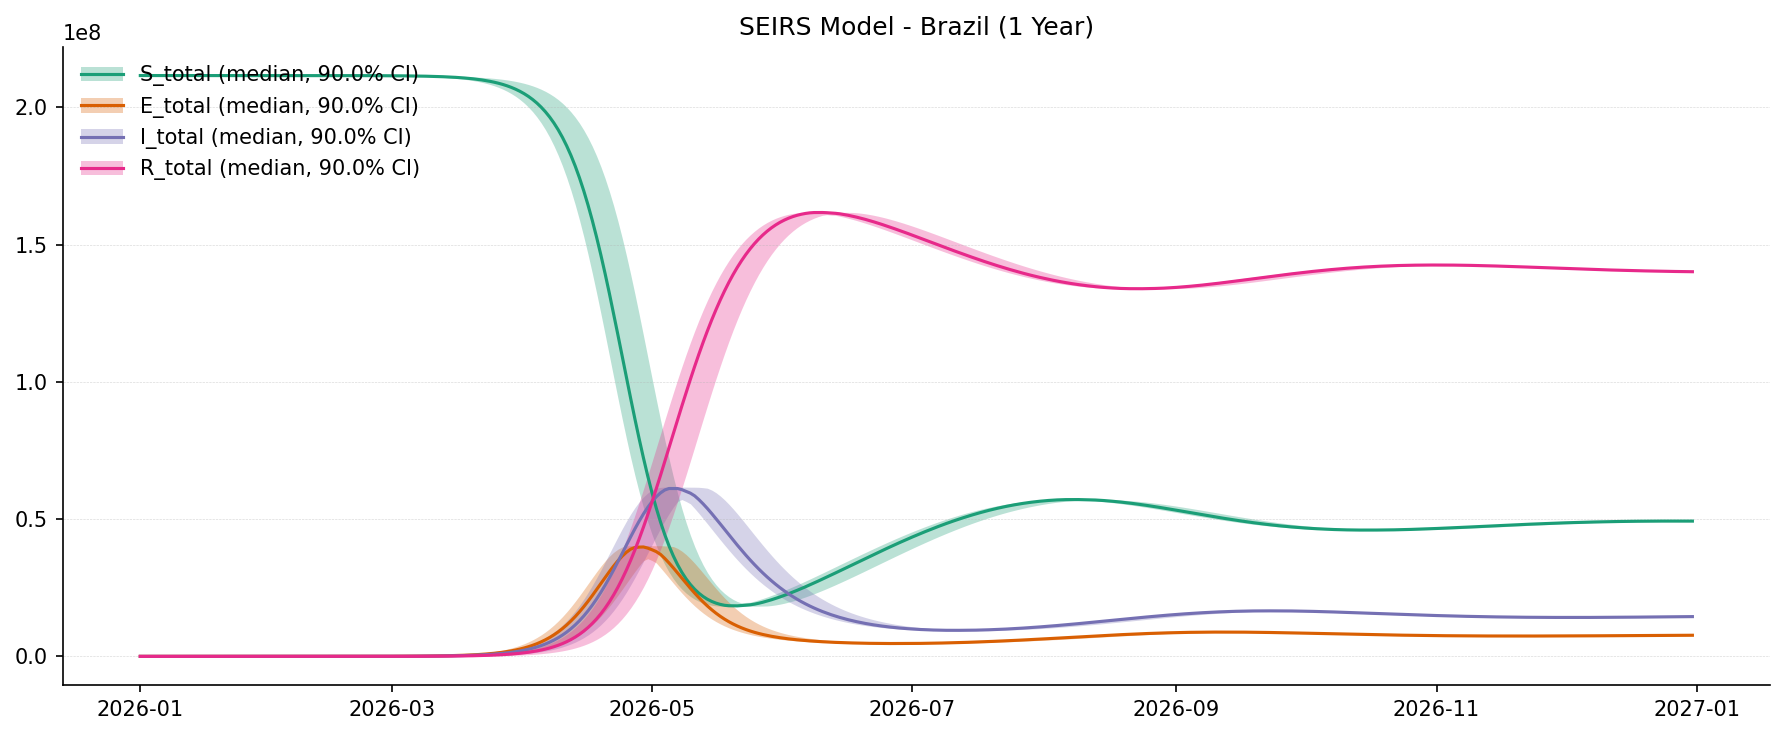

In [6]:
from epydemix.visualization import plot_quantiles

# Get quantiles
df_quantiles = results.get_quantiles_compartments()

# Plot all compartments
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
plot_quantiles(df_quantiles, columns=["S_total", "E_total", "I_total", "R_total"],
               title="SEIRS Model - Brazil (1 Year)", ax=ax)

<Axes: title={'center': 'Infections by Age Group'}>

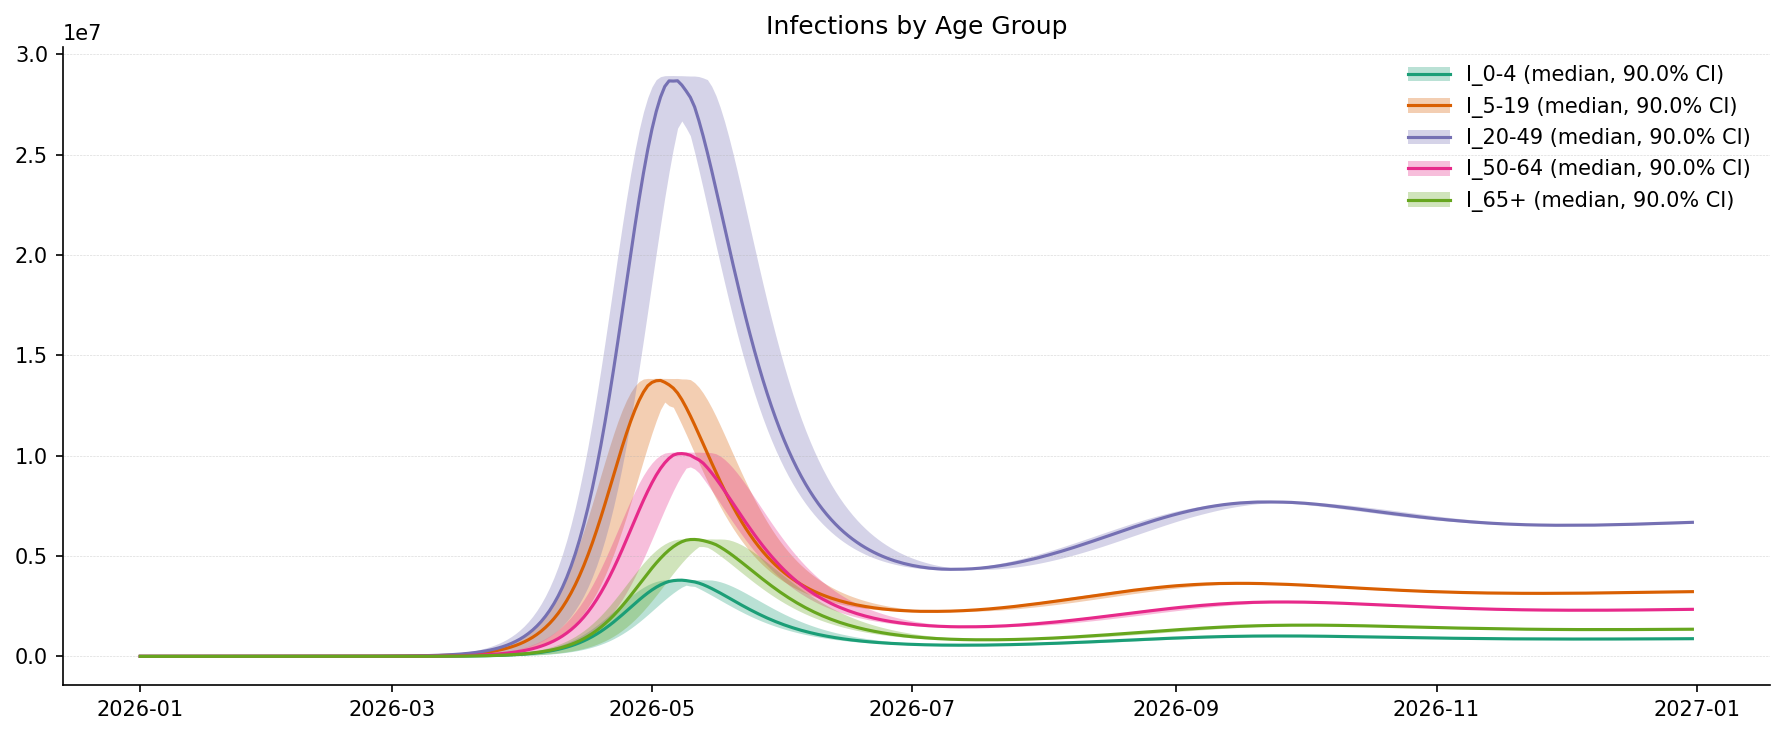

In [7]:
# Infections by age group
fig, ax = plt.subplots(figsize=(12, 5), dpi=150)
plot_quantiles(df_quantiles,
               columns=["I_0-4", "I_5-19", "I_20-49", "I_50-64", "I_65+"],
               title="Infections by Age Group", ax=ax, legend_loc="upper right")

## Task 4: Compare SEIRS vs SEIR

Let's compare the dynamics with and without waning immunity.

In [8]:
# Create standard SEIR model (no waning)
model_seir = EpiModel(name="SEIR Model", compartments=["S", "E", "I", "R"])

model_seir.add_transition(source="S", target="E", params=("beta", "I"), kind="mediated")
model_seir.add_transition(source="E", target="I", params="sigma", kind="spontaneous")
model_seir.add_transition(source="I", target="R", params="gamma", kind="spontaneous")
# No R → S transition!

model_seir.add_parameter("beta", 0.03)
model_seir.add_parameter("sigma", 0.2)
model_seir.add_parameter("gamma", 0.1)
model_seir.set_population(population)

# Run simulations
results_seir = model_seir.run_simulations(
    start_date="2026-01-01",
    end_date="2026-12-31",
    Nsim=50,
    percentage_in_agents=10 / population.Nk.sum()
)

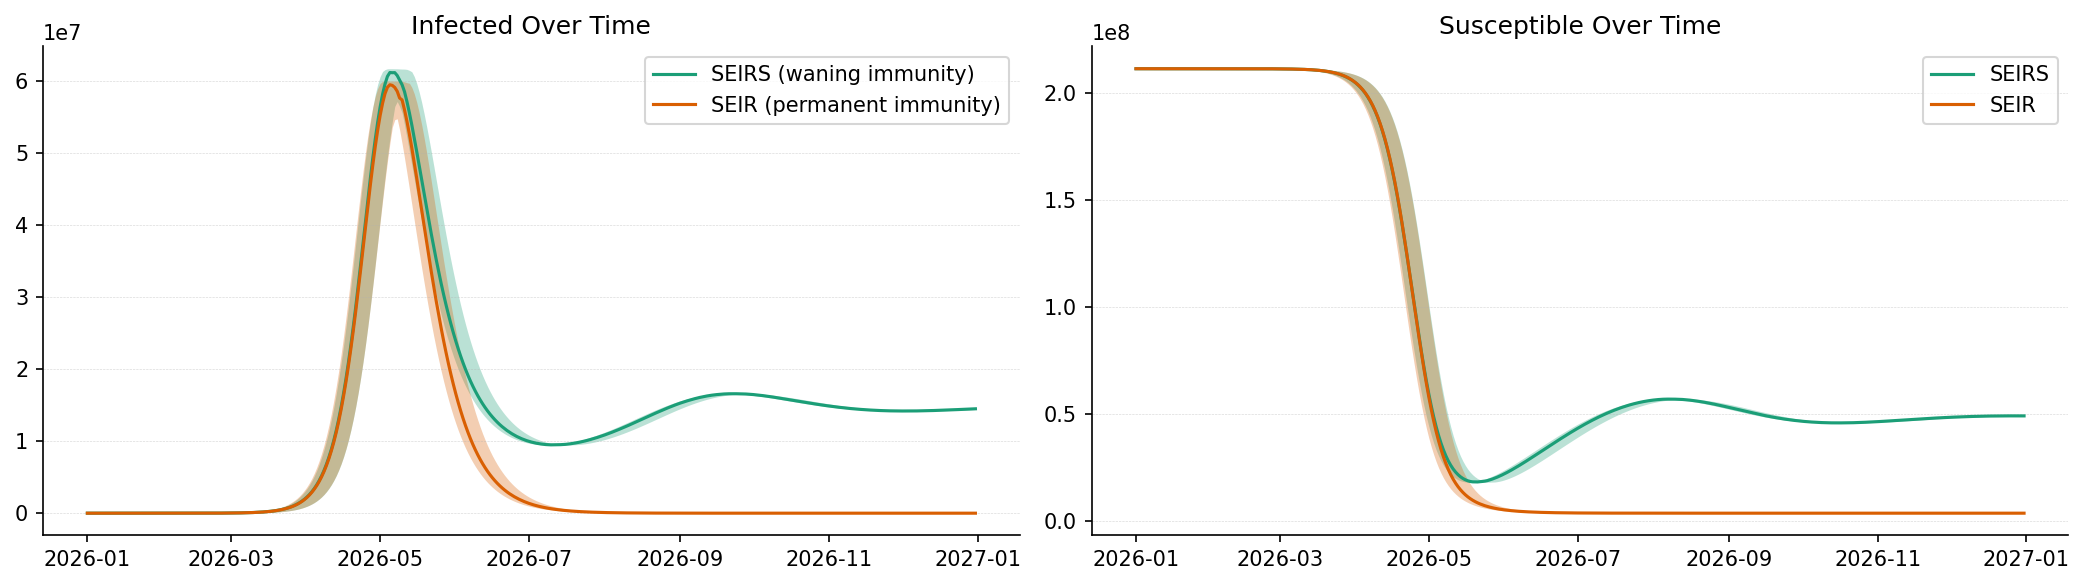

In [9]:
import seaborn as sns
colors = sns.color_palette("Dark2")

df_seir = results_seir.get_quantiles_compartments()

fig, axes = plt.subplots(1, 2, figsize=(14, 4), dpi=150)

# Infected comparison
plot_quantiles(df_quantiles, columns=["I_total"], ax=axes[0],
               colors=colors[0], labels=["SEIRS (waning immunity)"])
plot_quantiles(df_seir, columns=["I_total"], ax=axes[0],
               colors=colors[1], labels=["SEIR (permanent immunity)"])
axes[0].set_title("Infected Over Time")
axes[0].legend()

# Susceptible comparison
plot_quantiles(df_quantiles, columns=["S_total"], ax=axes[1],
               colors=colors[0], labels=["SEIRS"])
plot_quantiles(df_seir, columns=["S_total"], ax=axes[1],
               colors=colors[1], labels=["SEIR"])
axes[1].set_title("Susceptible Over Time")
axes[1].legend()

plt.tight_layout()

## Discussion

**How does waning immunity affect the long-term dynamics?**

1. **SEIR (permanent immunity):** The epidemic burns through the population once and then dies out when herd immunity is reached. Susceptibles decrease monotonically.

2. **SEIRS (waning immunity):** 
   - The susceptible pool is continuously replenished as recovered individuals lose immunity
   - This can lead to **recurrent epidemic waves** or **endemic equilibrium**
   - With ω=0.01 (100-day immunity), we see the infection persisting longer

**Key insight:** Waning immunity is crucial for modeling diseases where reinfection is possible (e.g., influenza, common cold coronaviruses, RSV). The rate of waning (ω) determines whether the disease becomes endemic or causes periodic epidemics.